In [1]:
using Connectomes
using ADNIDatasets
using CSV, DataFrames
using DrWatson: projectdir
using Distributions
using Serialization
using DelimitedFiles
using MCMCChains
using CairoMakie

In [2]:
include(projectdir("functions.jl"))
include(projectdir("adni/inference/inference-preamble.jl"));

In [3]:

pst = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-taupos-4x2000.jls"));
pst2 = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-tauneg-4x2000.jls"));
pst3 = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-abneg-4x2000.jls"));

In [4]:
function get_diff(d)
    d[:,end] .- d[:,1]
end

get_diff (generic function with 1 method)

In [31]:
subsuvr = [calc_suvr(data, i) for i in tau_neg]
_subdata = [normalise(sd, u0, cc) for sd in subsuvr]

blsd = [sd .- u0 for sd in _subdata]
nonzerosubs = findall(x -> sum(x) < 2, [sum(sd, dims=1) .== 0 for sd in blsd])

vols = [get_vol(data, i) for i in nonzerosubs]
atr = [v ./ v[:,1] for v in vols]
subdata = _subdata[nonzerosubs];

In [6]:
meanpst = mean(pst2)
production = [meanpst["α[$i]", :mean] for i in 1:39]
transport  = [meanpst["ρ[$i]", :mean] for i in 1:39];

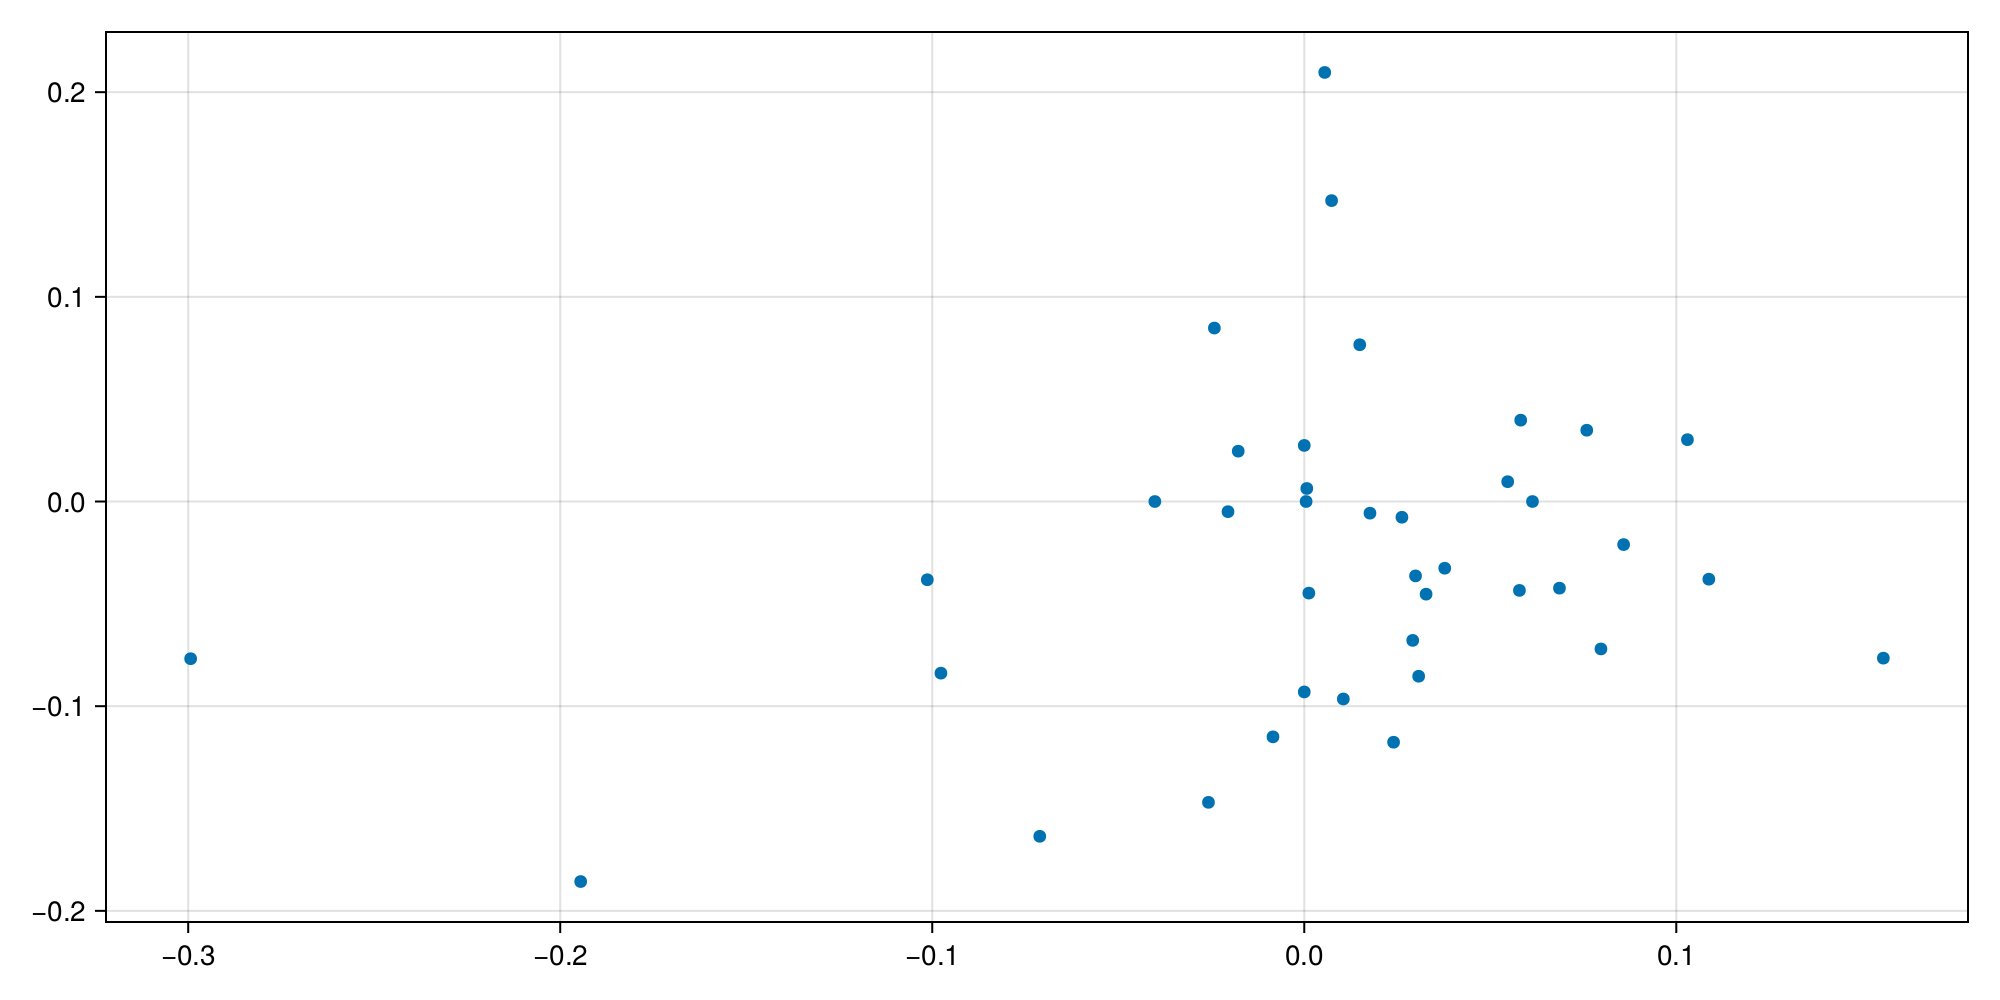

In [33]:
suvr_diff = mean.([get_diff(sd[mtl,:]) for sd in subdata])
vol_diff = mean.([get_diff(sd[mtl,:]) for sd in atr])

# diffs = mean.(get_diff.(subdata))

begin
    f = Figure(size=(1000,500))
    ax = Axis(f[1,1])
    scatter!(suvr_diff, vol_diff)
    f
end